## Import libraries

In [256]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import xgboost as xgb

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesClassifier
from sklearn.svm import SVR
from scipy.stats import randint, uniform

In [257]:
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder, DecisionTreeEncoder
from feature_engine.imputation import MeanMedianImputer
from feature_engine.selection import SelectByShuffling

In [258]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [259]:
pd.set_option('display.max_columns', None)

In [260]:
df = pd.read_csv('train.csv')

In [261]:
df.shape

(6495, 55)

In [262]:
df.head(5)

,property_id,property_name,property_summary,property_space,property_desc,property_neighborhood,property_notes,property_transit,property_access,property_interaction,property_rules,property_zipcode,property_lat,property_lon,property_type,property_room_type,property_max_guests,property_bathrooms,property_bedrooms,property_beds,property_bed_type,property_amenities,property_sqfeet,property_scraped_at,property_last_updated,host_id,host_since,host_location,host_about,host_response_time,host_response_rate,host_nr_listings,host_nr_listings_total,host_verified,booking_price_covers,booking_min_nights,booking_max_nights,booking_availability_30,booking_availability_60,booking_availability_90,booking_availability_365,booking_cancel_policy,reviews_num,reviews_first,reviews_last,reviews_rating,reviews_acc,reviews_cleanliness,reviews_checkin,reviews_communication,reviews_location,reviews_value,reviews_per_month,extra,target
0,1,"Chambre à louer,courte durée.","Je loue une chambre dans mon appartement ""atyp...","Espace duplex très grand et lumineux,la chambr...","Je loue une chambre dans mon appartement ""atyp...",NaN,NaN,Accès direct de la Gare du Nord ( 4 arrêts de...,NaN,Je suis entièrement disponible pour tout échan...,NaN,NaN,50.858451,4.376594,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"Internet, Wireless Internet, Kitchen, Smoking ...",NaN,2017-05-08,a week ago,10012530,2013-11-14,"Brussels, Brussels, Belgium",NaN,within a few hours,100.0,1.0,1.0,"email, phone, reviews",1,1,1125,7,37,67,96,flexible,23,2015-12-01,2017-05-01,97.0,10.0,9.0,10.0,10.0,9.0,10.0,1.31,Host Has Profile Pic,26
1,2,Urban Antwerp - Spacious & Authentic Herenhouse,Our place is a typical historic herenhuis clos...,The spaces in our house are all large with hig...,Our place is a typical historic herenhuis clos...,Bar and restaurants One of our favourite bars ...,NaN,In Antwerp we have the system with rental bike...,You will be able to access the following space...,We are always available to help and assist whe...,NaN,2600,51.194744,4.413748,House,Entire home/apt,4,1.5,2.0,2.0,Real Bed,"TV, Cable TV, Wireless Internet, Kitchen, Brea...",NaN,2017-05-12,4 weeks ago,100188333,2016-10-18,"Antwerp, Flanders, Belgium",NaN,within a few hours,75.0,1.0,1.0,"email, phone, reviews",1,2,15,0,0,25,25,flexible,1,2017-04-27,2017-04-27,100.0,10.0,10.0,10.0,10.0,8.0,10.0,1.00,"Host Has Profile Pic, Is Location Exact",75
2,3,comfortable apartment in friendly neighborhood,Nice and cozy apartment for couples who like t...,Nice proper and clean apartment. No personal s...,Nice and cozy apartment for couples who like t...,Op 5 minuten lopen zijn er 2 gezellig stadpark...,Public transport is next to the apartment and ...,Fiets verhuur voor de deur. (dag/weekkaart) vi...,As a good host I trust my guest. No secrets an...,"Ik ben altijd bereikbaar voor vragen, maar ben...",NaN,2018,51.192501,4.409351,Condominium,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"Wireless Internet, Kitchen, Free parking on pr...",NaN,2017-05-12,2 days ago,100228761,2016-10-18,"Antwerp, Flanders, Belgium",ik ben een expat die alleen mid weeks in Antwe...,within an hour,100.0,1.0,1.0,"email, phone, reviews",1,2,1125,20,34,55,330,flexible,4,2016-12-04,2017-05-07,93.0,10.0,10.0,9.0,9.0,9.0,10.0,0.75,"Host Has Profile Pic, Is Location Exact, Insta...",110
3,4,Historical City Antwerp.,The best place to stay if you like to be in th...,Our rooms are nice and spacious. You stay in a...,The best place to stay if you like to be in th...,In the middle of the historical city of Antwerp,Staying in our house you have to be able to cl...,Tram 10 and 11 from Central station stop in ou...,Beside your own room you can relax in the down...,We will be available to let you know where wha...,Respectful towards other guest and host! No pets!,2000,51.220145,4.405446,House,Private room,2,1.0,1.0,1.0,Real Bed,"TV, Internet, Wireless Internet, Breakfast, He...",NaN,2017-05-12,5 weeks ago,10026319,2013-11-15,Belgium,"Hello, I was born in the Nether

## Drop columns

In [263]:
print(df.property_scraped_at.max())
print(df.property_scraped_at.min())

2017-05-12
2017-05-08


In [264]:
# Date time columns 
def preprocess_dates(df):
    now = dt.datetime.now()

    df['host_since'] = pd.to_datetime(df['host_since'])
    df['host_days'] = (now - df['host_since']).dt.days
    df.drop('host_since', axis=1, inplace=True)

    df['reviews_first'] = pd.to_datetime(df['reviews_first'])
    df['reviews_first'] = (now - df['reviews_first']).dt.days

    df['reviews_last'] = pd.to_datetime(df['reviews_last'])
    df['reviews_last'] = (now - df['reviews_last']).dt.days
    
    return df


preprocess_dates(df)

,property_id,property_name,property_summary,property_space,property_desc,property_neighborhood,property_notes,property_transit,property_access,property_interaction,property_rules,property_zipcode,property_lat,property_lon,property_type,property_room_type,property_max_guests,property_bathrooms,property_bedrooms,property_beds,property_bed_type,property_amenities,property_sqfeet,property_scraped_at,property_last_updated,host_id,host_location,host_about,host_response_time,host_response_rate,host_nr_listings,host_nr_listings_total,host_verified,booking_price_covers,booking_min_nights,booking_max_nights,booking_availability_30,booking_availability_60,booking_availability_90,booking_availability_365,booking_cancel_policy,reviews_num,reviews_first,reviews_last,reviews_rating,reviews_acc,reviews_cleanliness,reviews_checkin,reviews_communication,reviews_location,reviews_value,reviews_per_month,extra,target,host_days
0,1,"Chambre à louer,courte durée.","Je loue une chambre dans mon appartement ""atyp...","Espace duplex très grand et lumineux,la chambr...","Je loue une chambre dans mon appartement ""atyp...",NaN,NaN,Accès direct de la Gare du Nord ( 4 arrêts de...,NaN,Je suis entièrement disponible pour tout échan...,NaN,NaN,50.858451,4.376594,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"Internet, Wireless Internet, Kitchen, Smoking ...",NaN,2017-05-08,a week ago,10012530,"Brussels, Brussels, Belgium",NaN,within a few hours,100.0,1.0,1.0,"email, phone, reviews",1,1,1125,7,37,67,96,flexible,23,2683.0,2166.0,97.0,10.0,9.0,10.0,10.0,9.0,10.0,1.31,Host Has Profile Pic,26,3430.0
1,2,Urban Antwerp - Spacious & Authentic Herenhouse,Our place is a typical historic herenhuis clos...,The spaces in our house are all large with hig...,Our place is a typical historic herenhuis clos...,Bar and restaurants One of our favourite bars ...,NaN,In Antwerp we have the system with rental bike...,You will be able to access the following space...,We are always available to help and assist whe...,NaN,2600,51.194744,4.413748,House,Entire home/apt,4,1.5,2.0,2.0,Real Bed,"TV, Cable TV, Wireless Internet, Kitchen, Brea...",NaN,2017-05-12,4 weeks ago,100188333,"Antwerp, Flanders, Belgium",NaN,within a few hours,75.0,1.0,1.0,"email, phone, reviews",1,2,15,0,0,25,25,flexible,1,2170.0,2170.0,100.0,10.0,10.0,10.0,10.0,8.0,10.0,1.00,"Host Has Profile Pic, Is Location Exact",75,2361.0
2,3,comfortable apartment in friendly neighborhood,Nice and cozy apartment for couples who like t...,Nice proper and clean apartment. No personal s...,Nice and cozy apartment for couples who like t...,Op 5 minuten lopen zijn er 2 gezellig stadpark...,Public transport is next to the apartment and ...,Fiets verhuur voor de deur. (dag/weekkaart) vi...,As a good host I trust my guest. No secrets an...,"Ik ben altijd bereikbaar voor vragen, maar ben...",NaN,2018,51.192501,4.409351,Condominium,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"Wireless Internet, Kitchen, Free parking on pr...",NaN,2017-05-12,2 days ago,100228761,"Antwerp, Flanders, Belgium",ik ben een expat die alleen mid weeks in Antwe...,within an hour,100.0,1.0,1.0,"email, phone, reviews",1,2,1125,20,34,55,330,flexible,4,2314.0,2160.0,93.0,10.0,10.0,9.0,9.0,9.0,10.0,0.75,"Host Has Profile Pic, Is Location Exact, Insta...",110,2361.0
3,4,Historical City Antwerp.,The best place to stay if you like to be in th...,Our rooms are nice and spacious. You stay in a...,The best place to stay if you like to be in th...,In the middle of the historical city of Antwerp,Staying in our house you have to be able to cl...,Tram 10 and 11 from Central station stop in ou...,Beside your own room you can relax in the down...,We will be available to let you know where wha...,Respectful towards other guest and host! No pets!,2000,51.220145,4.405446,House,Private room,2,1.0,1.0,1.0,Real Bed,"TV, Internet, Wireless Internet, Breakfast, He...",NaN,2017-05-12,5 weeks ago,10026319,Belgium,"Hello, I was born in the Netherlands and i sp...",within an hour,100.0,2.0,2.0,

In [265]:
len(df[df.booking_max_nights == df.booking_max_nights.median()])/len(df)


0.7006928406466513

In [266]:
# Columns where owners describe their properties

free_text_cols = ['property_name', 'property_summary', 'property_desc']

# Get columns with more than 30% missing values

missing_over_30 = df.columns[df.isnull().mean() > 0.3]
missing_over_30

Index(['property_space', 'property_neighborhood', 'property_notes',
       'property_transit', 'property_access', 'property_interaction',
       'property_rules', 'property_sqfeet', 'host_about'],
      dtype='object')

In [267]:
# Get the country of host location

df['host_location'] = df['host_location'].astype(str)

# Define a lambda function to extract the last element
last = lambda x: x.split(", ")[-1]

# Apply the lambda function 
countries = df['host_location'].apply(last)
countries = countries.replace('BE', 'Belgium')

# Top 10 countries of host location
countries.value_counts().sort_values(ascending=False).head(10)

Belgium           5854
France             212
Italy               51
US                  43
Spain               34
nan                 33
Netherlands         32
United States       23
United Kingdom      19
Germany             19
Name: host_location, dtype: int64

In [268]:
# Drop these columns out of both train and test sets
# Zip code is not necessary since we have longitude and latitude
# The date where data is scraped is of little importance 
# Drop booking_max_nights as many observations have value = 1125
# Drop host_location, host_verified, host_id, property_id since the variables are not informative 

cols_to_drop = free_text_cols + list(missing_over_30) + ["property_zipcode", "property_last_updated", "property_scraped_at", "booking_max_nights", "host_location", "host_verified", "host_id", "property_id"]

In [269]:
cols_to_drop

['property_name',
 'property_summary',
 'property_desc',
 'property_space',
 'property_neighborhood',
 'property_notes',
 'property_transit',
 'property_access',
 'property_interaction',
 'property_rules',
 'property_sqfeet',
 'host_about',
 'property_zipcode',
 'property_last_updated',
 'property_scraped_at',
 'booking_max_nights',
 'host_location',
 'host_verified',
 'host_id',
 'property_id']

In [270]:
df.drop(cols_to_drop, axis=1, inplace=True)

In [271]:
df.shape

(6495, 35)

In [272]:
# Make list of variables  types

# numerical: discrete vs continuous
discrete = [var for var in df.columns if df[var].dtype!='O' and var!='target' and df[var].nunique()<20]
continuous = [var for var in df.columns if df[var].dtype!='O' and var!='target' and var not in discrete]

# categorical
categorical = [var for var in df.columns if df[var].dtype=='O']

print('There are {} discrete variables'.format(len(discrete)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))

There are 11 discrete variables
There are 16 continuous variables
There are 7 categorical variables


## Missing value imputation

### Categorical variables

In [273]:
# Check cardinality

df[categorical].nunique()

property_type              23
property_room_type          3
property_bed_type           5
property_amenities       6057
host_response_time          4
booking_cancel_policy       4
extra                      43
dtype: int64

In [274]:
# Check missing values
missing_cat =  df[categorical].isnull().mean()
missing_cat = missing_cat[missing_cat > 0]
missing_cat

property_amenities    0.008006
host_response_time    0.224942
extra                 0.000770
dtype: float64

In [275]:
df['extra'] = df['extra'].apply(lambda x: str(x).count(',') + 1) # count number of extra values

In [276]:
# Fill missing values

df['host_response_time'] = df['host_response_time'].fillna('Unknown')
df['property_amenities'] = df['property_amenities'].fillna('Unknown')

In [277]:
df[categorical].isnull().mean()

property_type            0.0
property_room_type       0.0
property_bed_type        0.0
property_amenities       0.0
host_response_time       0.0
booking_cancel_policy    0.0
extra                    0.0
dtype: float64

### Numerical variables

In [278]:
numeric = discrete + continuous
# Check missing values of discrete variables
missing_num= df[numeric].isnull().mean()
missing_num = missing_num[missing_num > 0]
missing_num

property_bathrooms        0.001848
property_bedrooms         0.001386
property_beds             0.001694
reviews_acc               0.215396
reviews_cleanliness       0.215089
reviews_checkin           0.215704
reviews_communication     0.214935
reviews_location          0.216012
reviews_value             0.216320
host_response_rate        0.224942
host_nr_listings          0.000154
host_nr_listings_total    0.000154
reviews_first             0.198614
reviews_last              0.198614
reviews_rating            0.212933
reviews_per_month         0.198614
host_days                 0.000154
dtype: float64

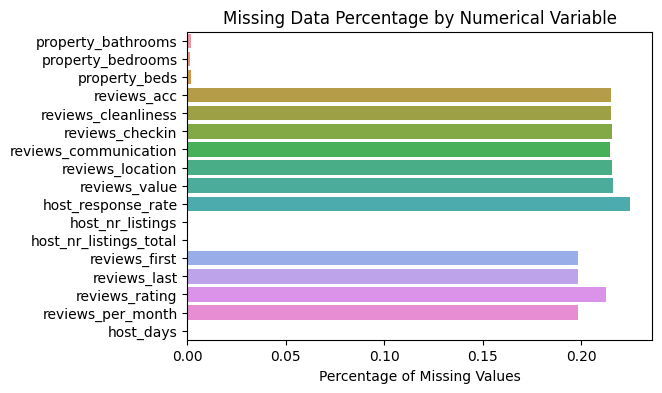

In [279]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar plot using seaborn
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=missing_num.values, y=missing_num.index, ax=ax)

# Set the axis labels and title
ax.set_xlabel('Percentage of Missing Values')
ax.set_title('Missing Data Percentage by Numerical Variable')

# Show the plot
plt.show()


In [280]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=7)
train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)

X_train = train_df.drop('target',axis=1).iloc[:,1:]
y_train = train_df['target']
X_val = val_df.drop('target',axis=1).iloc[:,1:]
y_val = val_df['target']

In [281]:
# Impute median value 
median_imputer = MeanMedianImputer(imputation_method="median", 
                                   variables=["property_bathrooms", "property_bedrooms", "property_beds",
                                              "host_nr_listings", "host_nr_listings_total"])
median_imputer.fit(X_train)
X_train = median_imputer.transform(X_train)
X_val = median_imputer.transform(X_val)

In [282]:
# Column starts with "reviews"
reviews_cols = X_train.filter(regex='^reviews', axis=1).columns.to_list()
impute_cols = reviews_cols + ['host_response_rate', 'host_days']
impute_vals = X_train[impute_cols].max(axis=0).tolist()
impute_vals

[386.0,
 4556.0,
 4534.0,
 100.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 19.9,
 100.0,
 5334.0]

In [283]:
# Impute missing value for the reviews variables with max value 
# Fit and transform 
for i in range(len(impute_cols)):
    simple_imputer = SimpleImputer(strategy='constant', fill_value=impute_vals[i])
    X_train[[impute_cols[i]]] = simple_imputer.fit_transform(X_train[[impute_cols[i]]])
    X_val[[impute_cols[i]]] = simple_imputer.transform(X_val[[impute_cols[i]]])


In [284]:
# No missing value left

X_train.isnull().any().sum()

0

## Variables encoding

For `property_type`, there are many labels that rarely appear. We shall group all these labels together under the new category "Other_property_type"

In [285]:
df.groupby("property_type")['extra'].count() / len(df)

property_type
Apartment             0.764434
Bed & Breakfast       0.025558
Boat                  0.000154
Boutique hotel        0.000308
Cabin                 0.001078
Camper/RV             0.000154
Castle                0.000462
Chalet                0.000154
Condominium           0.012009
Dorm                  0.000308
Earth House           0.000154
Guest suite           0.000308
Guesthouse            0.005389
Hostel                0.000308
House                 0.136721
Loft                  0.026328
Other                 0.004619
Serviced apartment    0.000616
Tent                  0.000154
Timeshare             0.000154
Townhouse             0.017552
Villa                 0.002925
Yurt                  0.000154
Name: extra, dtype: float64

In [286]:
# Create a RareLabelEncoder object
rare_encoder = RareLabelEncoder(tol=0.01, n_categories=2, variables=['property_type'])

# Fit and transform the encoder 
X_train = rare_encoder.fit_transform(X_train)
X_val = rare_encoder.transform(X_val)

In [287]:
X_train.property_type.unique()

array(['Apartment', 'House', 'Loft', 'Townhouse', 'Bed & Breakfast',
       'Rare', 'Condominium'], dtype=object)

In [288]:
# Create a dictionary to store the count of each amenity
amenities_count = {}

# Loop through the rows and count the amenities
for am_list in X_train['property_amenities'].astype(str):
    for am in am_list.split(', '):
        if am in amenities_count:
            amenities_count[am] += 1
        else:
            amenities_count[am] = 1

# Print the count of each amenity
for am, count in amenities_count.items():
    print(f"{am}: {count}")

TV: 2837
Wireless Internet: 4951
Kitchen: 4742
Smoking allowed: 825
Washer: 3021
Internet: 2966
Free parking on premises: 803
Doorman: 64
Breakfast: 608
Indoor fireplace: 322
Heating: 4949
Smoke detector: 3292
Carbon monoxide detector: 1093
First aid kit: 1273
Fire extinguisher: 1884
Essentials: 4537
Shampoo: 3009
Hair dryer: 2681
Iron: 2522
Laptop friendly workspace: 2618
translation missing: en.hosting_amenity_49: 1105
translation missing: en.hosting_amenity_50: 1419
Bed linens: 39
Extra pillows and blankets: 18
Wide doorway: 26
Accessible-height bed: 4
Safety card: 919
Hangers: 2908
Private entrance: 290
Wheelchair accessible: 349
Buzzer/wireless intercom: 1963
Family/kid friendly: 2860
Self Check-In: 232
Doorman Entry: 78
Pets allowed: 548
24-hour check-in: 1224
Cable TV: 1506
Suitable for events: 285
Elevator in building: 1509
Dryer: 1487
Air conditioning: 269
Lock on bedroom door: 738
Table corner guards: 5
Hot tub: 177
Keypad: 44
Gym: 89
Bathtub: 119
Game console: 15
Microwave: 

In [289]:
total_rows = len(X_train)

popular_amenities_count = {amenity: count for amenity, count in amenities_count.items() if count/total_rows > 0.25} # filter amenities that appear more than 30%
del(popular_amenities_count['translation missing: en.hosting_amenity_50'])
popular_amenities = list(popular_amenities_count.keys())
popular_amenities

['TV',
 'Wireless Internet',
 'Kitchen',
 'Washer',
 'Internet',
 'Heating',
 'Smoke detector',
 'Fire extinguisher',
 'Essentials',
 'Shampoo',
 'Hair dryer',
 'Iron',
 'Laptop friendly workspace',
 'Hangers',
 'Buzzer/wireless intercom',
 'Family/kid friendly',
 'Cable TV',
 'Elevator in building',
 'Dryer']

In [290]:
from sklearn.preprocessing import MultiLabelBinarizer

# Convert the comma-separated values in 'property_amenities' column to a list of amenities
train_amenities = X_train['property_amenities'].astype(str).str.split(", ")
val_amenities = X_val['property_amenities'].astype(str).str.split(", ")

# Create an instance of MultiLabelBinarizer and fit it on the amenities list
mlb = MultiLabelBinarizer(classes=popular_amenities)
train_amenities = mlb.fit_transform(train_amenities)
val_amenities = mlb.transform(val_amenities)

# Create a new DataFrame with the one hot encoded columns
train_amenities = pd.DataFrame(train_amenities, columns=mlb.classes_)
val_amenities = pd.DataFrame(val_amenities, columns=mlb.classes_)

# Concat one hot encoded columns and drop the original columns
X_train = pd.concat([X_train, train_amenities], axis=1)
X_train.drop(columns="property_amenities", axis=1, inplace=True)

X_val = pd.concat([X_val, val_amenities], axis=1)
X_val.drop(columns="property_amenities", axis=1, inplace=True)

In [291]:
X_train.shape

(5196, 52)

In [292]:
# set up the encoder
# encoder = DecisionTreeEncoder(
#      variables=['property_type','property_room_type', 'property_bed_type', 
#                 'host_response_time','booking_cancel_policy'],
#      regression=True,
#      cv=3,
#      random_state=7)

# One hot encode other categorical variables 
encoder = OneHotEncoder(
    variables = ['property_type','property_room_type', 'property_bed_type', 
                'host_response_time','booking_cancel_policy'],  
    drop_last=True,  
)

# fit the encoder
encoder.fit(X_train, y_train)
# transform the data
X_train = encoder.transform(X_train)
X_val = encoder.transform(X_val)


In [293]:
X_train.head(3)

,property_lat,property_lon,property_max_guests,property_bathrooms,property_bedrooms,property_beds,host_response_rate,host_nr_listings,host_nr_listings_total,booking_price_covers,booking_min_nights,booking_availability_30,booking_availability_60,booking_availability_90,booking_availability_365,reviews_num,reviews_first,reviews_last,reviews_rating,reviews_acc,reviews_cleanliness,reviews_checkin,reviews_communication,reviews_location,reviews_value,reviews_per_month,extra,host_days,TV,Wireless Internet,Kitchen,Washer,Internet,Heating,Smoke detector,Fire extinguisher,Essentials,Shampoo,Hair dryer,Iron,Laptop friendly workspace,Hangers,Buzzer/wireless intercom,Family/kid friendly,Cable TV,Elevator in building,Dryer,property_type_Apartment,property_type_House,property_type_Loft,property_type_Townhouse,property_type_Bed & Breakfast,property_type_Rare,property_room_type_Entire home/apt,property_room_type_Private room,property_bed_type_Real Bed,property_bed_type_Pull-out Sofa,property_bed_type_Couch,property_bed_type_Futon,host_response_time_Unknown,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_within a day,booking_cancel_policy_flexible,booking_cancel_policy_strict,booking_cancel_policy_moderate
0,50.821346,4.380675,4,1.0,2.0,1.0,100.0,1.0,1.0,1,6,0,0,0,0,0,4556.0,4534.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,19.90,2,2829.0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0
1,50.827112,4.372949,2,1.0,1.0,1.0,100.0,1.0,1.0,1,1,27,57,87,87,0,4556.0,4534.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,19.90,3,2635.0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0
2,50.864091,4.365768,1,1.0,1.0,1.0,100.0,1.0,1.0,1,1,15,23,36,36,25,2268.0,2165.0,89.0,9.0,9.0,9.0,10.0,9.0,9.0,6.76,3,2283.0,1,1,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1


## Feature Selection & Modelling

In [307]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

In [308]:
X_train_scaled.shape

(5196, 66)

In [296]:
# index = y_train[y_train > 160].index.to_list()
#X_train = X_train.drop(X_train.index[index])
#y_train = y_train[y_train <= 160]

In [309]:
from feature_engine.selection import DropCorrelatedFeatures, SmartCorrelatedSelection

# random forest
rf = RandomForestRegressor(
    n_estimators=10,
    random_state=7,
    n_jobs=1
)

# correlation selector
sel = SmartCorrelatedSelection(
    variables=None, # if none, selector examines all numerical variables
    threshold=0.8,
    missing_values="raise",
    selection_method="model_performance",
    estimator=rf,
    scoring='neg_root_mean_squared_error',
    cv=3
)

sel.fit(X_train_scaled, y_train)

SmartCorrelatedSelection(estimator=RandomForestRegressor(n_estimators=10,
                                                         n_jobs=1,
                                                         random_state=7),
                         missing_values='raise',
                         scoring='neg_root_mean_squared_error',
                         selection_method='model_performance')

In [310]:
sel.correlated_feature_sets_

[{'property_beds', 'property_max_guests'},
 {'host_nr_listings', 'host_nr_listings_total'},
 {'booking_availability_30',
  'booking_availability_60',
  'booking_availability_90'},
 {'reviews_first', 'reviews_last', 'reviews_per_month'},
 {'property_room_type_Entire home/apt', 'property_room_type_Private room'},
 {'property_bed_type_Pull-out Sofa', 'property_bed_type_Real Bed'}]

In [311]:
sel.features_to_drop_

['property_max_guests',
 'host_nr_listings_total',
 'booking_availability_60',
 'booking_availability_90',
 'reviews_first',
 'reviews_per_month',
 'property_room_type_Entire home/apt',
 'property_bed_type_Pull-out Sofa']

In [312]:
X_train_scaled = X_train_scaled.drop(sel.features_to_drop_, axis=1)
X_val_scaled = X_val_scaled.drop(sel.features_to_drop_, axis=1)

In [313]:
X_train_scaled.shape

(5196, 58)

In [318]:
from sklearn.ensemble import RandomForestClassifier

tree_model = RandomForestRegressor(max_depth=30, random_state=0)
tree_model.fit(X_train_scaled,y_train)


RandomForestRegressor(max_depth=30, random_state=0)

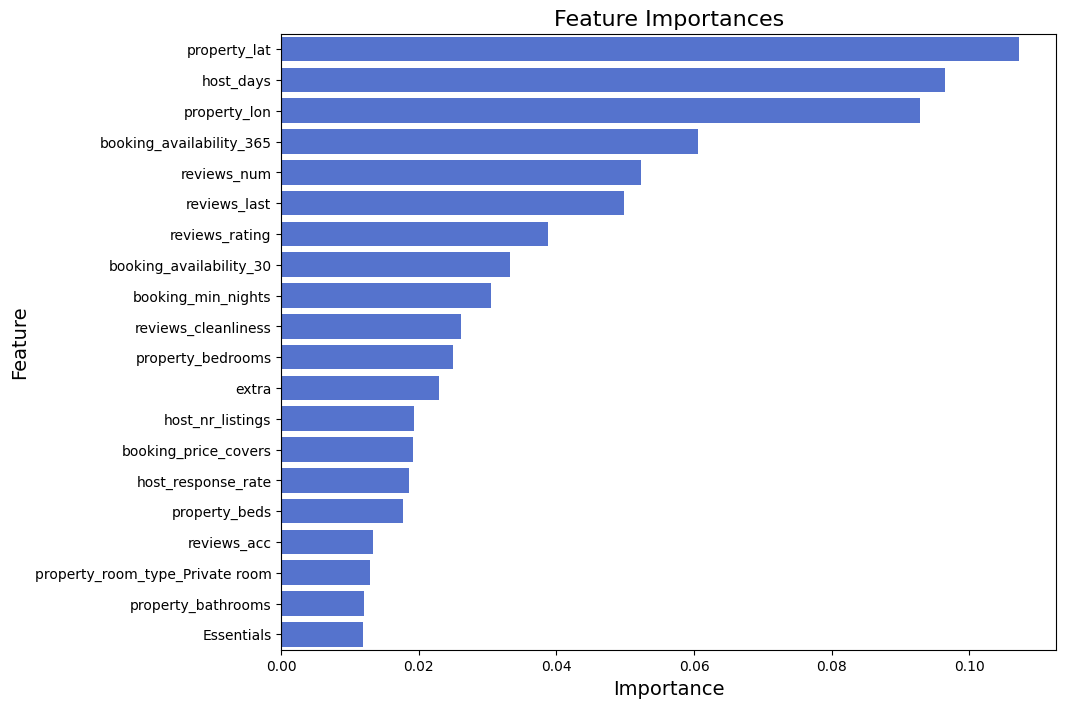

In [321]:
# Create a dataframe of features and their importances
importances_df = pd.DataFrame({'Feature': X_train_scaled.columns, 'Importance': tree_model.feature_importances_})

# Sort the features by importance in descending order
importances_df = importances_df.sort_values('Importance', ascending=False)

# Create a horizontal bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(20), color='royalblue')

# Set the title and axis labels
plt.title('Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.show()

In [322]:
# Define the model parameters
model_params = {
    'random_forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'max_depth': randint(3, 50),
            'max_features': ['auto', 'sqrt'],
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'bootstrap': [True, False]
        }
    },
    'gradient_boosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'learning_rate': uniform(0.01, 0.5),
            'max_depth': randint(1, 10),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10)
        }
    },
    
    'xgboost': {
        'model': xgboost.XGBRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'learning_rate': uniform(0.01, 0.5),
            'max_depth': randint(1, 10),
            'min_child_weight': randint(1, 10),
            'gamma': uniform(0, 1),
            'reg_alpha': uniform(0, 1),
            'reg_lambda': uniform(0, 1),
        }
    }
    
}

params_dict = {}

# Loop through each model in model_params and run RandomizedSearchCV
for model_name, model_info in model_params.items():
    print("Running RandomizedSearchCV for {}...".format(model_name))
    
    # Create a RandomizedSearchCV object for the current model
    model = model_info['model']
    param_dist = model_info['params']
    random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                       n_iter=10, cv=5, n_jobs=1, random_state=7)
    
    # Fit the RandomizedSearchCV object to the data
    random_search.fit(X_train_scaled, y_train)
    
    # Print the best parameters and score
    params_dict[model_name] = random_search.best_params_
    print("Best parameters for {}: ".format(model_name), random_search.best_params_)
    print("Best score for {}: ".format(model_name), random_search.best_score_)
    print("\n")


Running RandomizedSearchCV for random_forest...
Best parameters for random_forest:  {'bootstrap': False, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 69}
Best score for random_forest:  -0.007595142837619262


Running RandomizedSearchCV for gradient_boosting...
Best parameters for gradient_boosting:  {'learning_rate': 0.41186951805218774, 'max_depth': 1, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 69}
Best score for gradient_boosting:  -0.011774328207308305


Running RandomizedSearchCV for xgboost...
Best parameters for xgboost:  {'gamma': 0.9579137289076647, 'learning_rate': 0.0997884464734246, 'max_depth': 1, 'min_child_weight': 6, 'n_estimators': 86, 'reg_alpha': 0.4528429325464004, 'reg_lambda': 0.3529783659443947}
Best score for xgboost:  -0.012532800124440779




In [323]:
params_dict 

{'random_forest': {'bootstrap': False,
  'max_depth': 7,
  'max_features': 'sqrt',
  'min_samples_leaf': 7,
  'min_samples_split': 5,
  'n_estimators': 69},
 'gradient_boosting': {'learning_rate': 0.41186951805218774,
  'max_depth': 1,
  'min_samples_leaf': 8,
  'min_samples_split': 8,
  'n_estimators': 69},
 'xgboost': {'gamma': 0.9579137289076647,
  'learning_rate': 0.0997884464734246,
  'max_depth': 1,
  'min_child_weight': 6,
  'n_estimators': 86,
  'reg_alpha': 0.4528429325464004,
  'reg_lambda': 0.3529783659443947}}

In [ ]:
from sklearn.metrics import mean_absolute_error
gb_params = params_dict['gradient_boosting']

gb = GradientBoostingRegressor(**gb_params, random_state=7)

gb.fit(X_train_scaled, y_train)

train_preds = gb.predict(X_train_scaled)
val_preds = gb.predict(X_val_scaled)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train)))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val)))
print("Train MAE:", mean_absolute_error(train_preds, y_train))
print("Val MAE:", mean_absolute_error(val_preds, y_val))

Train RMSE: 48.25653562137986
Val RMSE: 61.99119243879444
Train MAE: 30.087285341934017
Val MAE: 33.41563568223383


In [ ]:
rf_params = params_dict['random_forest']

rf = RandomForestRegressor(**rf_params, random_state=7)

rf.fit(X_train_scaled, y_train)

train_preds = rf.predict(X_train_scaled)
val_preds = rf.predict(X_val_scaled)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train)))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val)))
print("Train MAE:", mean_absolute_error(train_preds, y_train))
print("Val MAE:", mean_absolute_error(val_preds, y_val))

Train RMSE: 47.08710712565325
Val RMSE: 61.78913091551431
Train MAE: 29.21471606944558
Val MAE: 33.350013868787656


In [ ]:
import xgboost

xgb_params = params_dict['xgboost']

xgb = xgboost.XGBRegressor(**xgb_params, random_state=7)

xgb.fit(X_train_scaled, y_train)

train_preds = xgb.predict(X_train_scaled)
val_preds = xgb.predict(X_val_scaled)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train)))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val)))
print("Train MAE:", mean_absolute_error(train_preds, y_train))
print("Val MAE:", mean_absolute_error(val_preds, y_val))

Train RMSE: 48.71107216960317
Val RMSE: 61.74500762754054
Train MAE: 30.218002527103323
Val MAE: 33.27516297361684


In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint

# # Define the parameter grid 
# param_dist = {
#     'n_estimators': randint(50, 100),
#     'max_depth': randint(10, 30),
#     'max_features': ['auto', 'sqrt'],
#     'min_samples_split': randint(2, 10),
#     'min_samples_leaf': randint(1, 5),
#     'bootstrap': [True, False]
# }

# # Create a RandomForestRegressor model
# rf = RandomForestRegressor()

# # Create a RandomizedSearchCV object with 5-fold cross-validation
# regr = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
#                                    n_iter=10, cv=5, n_jobs=-1, random_state=7)

# # Fit the RandomizedSearchCV object to the data
# regr.fit(X_train, y_train)

# # Print the best parameters and score
# print("Best parameters: ", regr.best_params_)


In [ ]:
## Test set
X_test = pd.read_csv('test.csv')
id = X_test.property_id

# Date columns
preprocess_dates(X_test)
# Drop columns
X_test.drop(cols_to_drop, axis=1, inplace=True)

# Impute categorical missing values 
# Extra column will indicate whether host is superhost
X_test['extra'] = X_test['extra'].fillna(0)
X_test.extra = X_test.extra.str.count(",") + 1
X_test['host_response_time'] = X_test['host_response_time'].fillna('Unknown')
X_test['property_amenities'] = X_test['property_amenities'].fillna('Unknown')

# Impute numerical missing values
X_test = median_imputer.transform(X_test)
for i in range(len(impute_cols)):
    simple_imputer = SimpleImputer(strategy='constant', fill_value=impute_vals[i])
    X_train[[impute_cols[i]]] = simple_imputer.fit_transform(X_train[[impute_cols[i]]])
    X_test[[impute_cols[i]]] = simple_imputer.transform(X_test[[impute_cols[i]]])
    
# Apply rare encoder on property_type
X_test = rare_encoder.transform(X_test)

# Amenities
test_amenities = X_test['property_amenities'].astype(str).str.split(", ")
test_amenities = mlb.transform(test_amenities)
test_amenities = pd.DataFrame(test_amenities, columns=mlb.classes_)
X_test = pd.concat([X_test, test_amenities], axis=1)
X_test.drop(columns="property_amenities", axis=1, inplace=True)

# one hot encoding
X_test = encoder.transform(X_test)

# Scale
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Feature selection
X_test = X_test.drop(sel.features_to_drop_, axis=1)


In [ ]:
# Train on full data

X_df = pd.concat([X_train_scaled, X_val_scaled], axis=0)
y_df = pd.concat([y_train, y_val], axis=0)

model = xgboost.XGBRegressor(**xgb_params, random_state=7)
model.fit(X_df, y_df)

y_pred = model.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['y_pred'])
y_pred.index = id

y_pred.to_csv('pred5.csv', header=False)

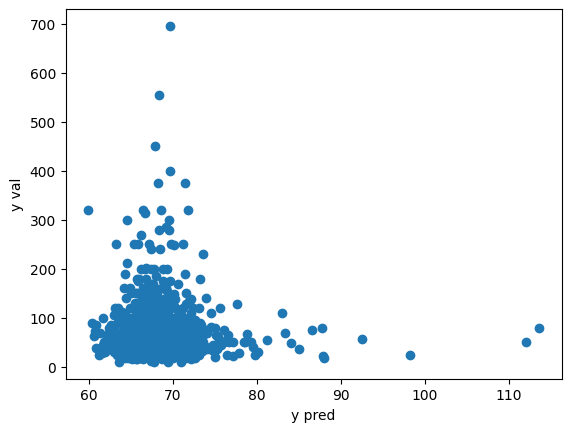

In [ ]:
plt.scatter(model.predict(X_val_scaled), y_val)
plt.xlabel('y pred')
plt.ylabel('y val')
plt.show()

## EDA

In [ ]:
df['target'].quantile(0.95)

150.0

In [ ]:
len(df[df.property_lat < 51])/len(df)

0.8289453425712087

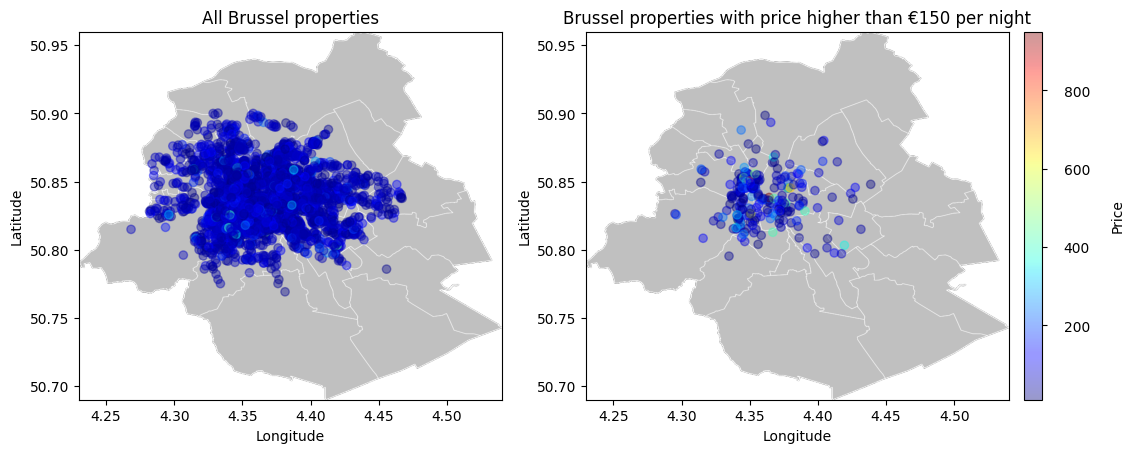

In [ ]:
# Plot the data on top of the map using scatterplot

brussel_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Municipalities_Brussels-Capital_Belgium_Map.svg/800px-Municipalities_Brussels-Capital_Belgium_Map.svg.png"

import urllib.request

# Download the image and save it locally
urllib.request.urlretrieve(brussel_url, "brussel.png")

# Read the image using matplotlib
brussel_map = plt.imread("brussel.png")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax[0].imshow(brussel_map, extent=[4.23, 4.54, 50.69, 50.96])
scatter1 = ax[0].scatter(df.loc[df.property_lat < 51, "property_lon"], 
                     df.loc[df.property_lat < 51, "property_lat"], 
                     c=df.loc[df.property_lat < 51,"target"],
                     cmap=plt.get_cmap("jet"),
                     alpha=0.4)
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")
ax[0].set_title("All Brussel properties")

high = df[df.target > 150]

ax[1].imshow(brussel_map, extent=[4.23, 4.54, 50.69, 50.96])
scatter2 = ax[1].scatter(high.loc[high.property_lat < 51, "property_lon"], 
                     high.loc[high.property_lat < 51, "property_lat"], 
                     c=high.loc[high.property_lat < 51,"target"],
                     cmap=plt.get_cmap("jet"),
                     alpha=0.4)
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")
ax[1].set_title("Brussel properties with price higher than €150 per night")

cbar = fig.colorbar(scatter1, ax=ax.ravel().tolist())
cbar.ax.set_ylabel("Price")
cbar.ax.yaxis.labelpad = 15
cbar.ax.tick_params(axis='y', which='major', pad=12)

pos = ax[1].get_position()
cbar.ax.set_position([pos.x1+0.01, pos.y0, 0.02, pos.height])
plt.show()

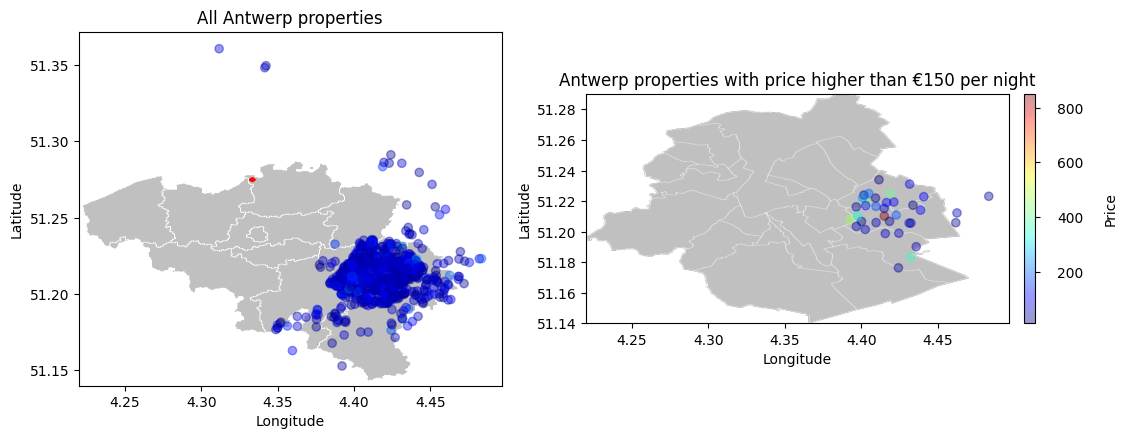

In [ ]:
antwerp_url = "https://upload.wikimedia.org/wikipedia/commons/6/64/Map_of_Antwerpen_in_belgium.PNG"

# Download the image and save it locally
urllib.request.urlretrieve(antwerp_url, "antwerp.png")

# Read the image using matplotlib
antwerp_map = plt.imread("antwerp.png")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax[0].imshow(antwerp_map, extent=[4.22, 4.47, 51.14, 51.29])
scatter1 = ax[0].scatter(df.loc[df.property_lat > 51, "property_lon"], 
                     df.loc[df.property_lat > 51, "property_lat"], c=df.loc[df.property_lat> 51,"target"],
                     cmap=plt.get_cmap("jet"),
                     alpha=0.4)
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")
ax[0].set_title("All Antwerp properties")

high = df[df.target > 160]

ax[1].imshow(brussel_map, extent=[4.22, 4.47, 51.14, 51.29])
scatter2 = ax[1].scatter(high.loc[high.property_lat > 51, "property_lon"], 
                     high.loc[high.property_lat > 51, "property_lat"], c=high.loc[high.property_lat > 51,"target"],
                     cmap=plt.get_cmap("jet"),
                     alpha=0.4)
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")
ax[1].set_title("Antwerp properties with price higher than €150 per night")

cbar = fig.colorbar(scatter1, ax=ax.ravel().tolist())
cbar.ax.set_ylabel("Price")
cbar.ax.yaxis.labelpad = 15
cbar.ax.tick_params(axis='y', which='major', pad=12)

pos = ax[1].get_position()
cbar.ax.set_position([pos.x1+0.01, pos.y0, 0.02, pos.height])
plt.show()

In [ ]:
test = pd.read_csv('test.csv')

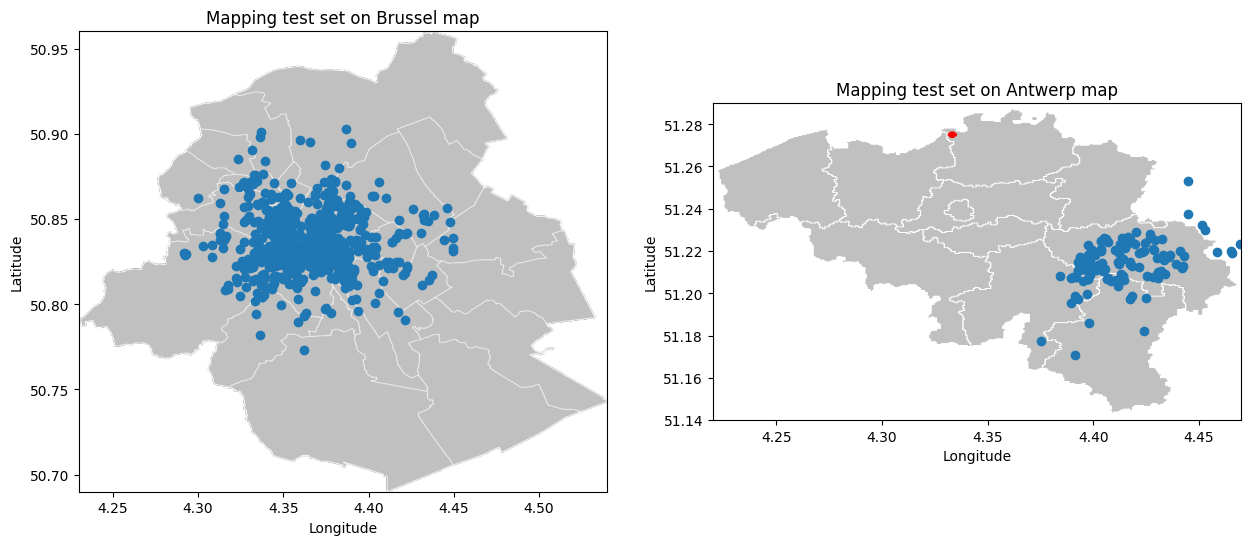

In [ ]:
# Plot the data on top of the map using scatterplot

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax[0].imshow(brussel_map, extent=[4.23, 4.54, 50.69, 50.96])
scatter1 = ax[0].scatter(test.loc[test.property_lat < 51, "property_lon"], 
                     test.loc[test.property_lat < 51, "property_lat"])
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")
ax[0].set_title("Mapping test set on Brussel map")

ax[1].imshow(antwerp_map, extent=[4.22, 4.47, 51.14, 51.29])
scatter2 = ax[1].scatter(test.loc[test.property_lat > 51, "property_lon"], 
                     test.loc[test.property_lat > 51, "property_lat"])
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")
ax[1].set_title("Mapping test set on Antwerp map")

plt.show()

In [ ]:
import plotly.express as px

# Define the color palette
colors = px.colors.qualitative.Pastel

# Create a boxplot using Plotly
fig = px.box(df, x="property_type", y="target", color="property_type", color_discrete_sequence=colors)

# Set the axis labels, title, and legend
fig.update_xaxes(title="", tickangle=45, tickfont=dict(size=7))
fig.update_yaxes(title="Price", tickfont=dict(size=10))
fig.update_layout(title="Property Type vs Price", width=800, height=400, showlegend=False)
fig.update_traces(marker=dict(size=2), jitter=0.5, hovertemplate='Price: %{y}')

# Show the plot
fig.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


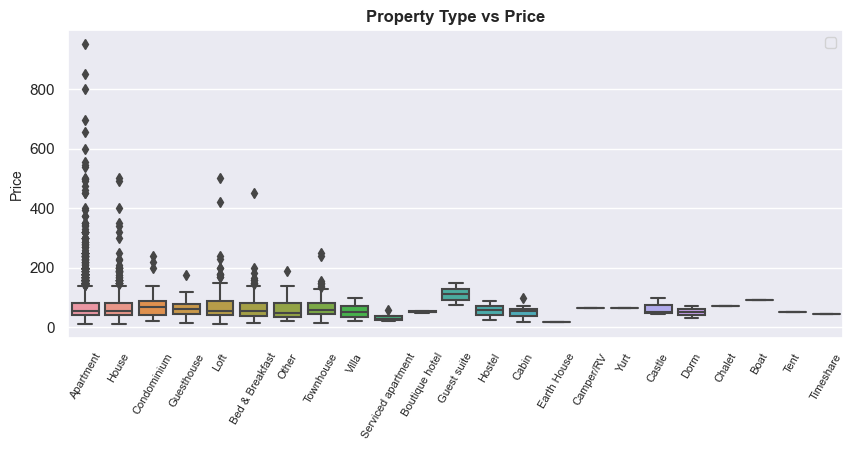

In [ ]:

sns.set_theme(context='notebook', style='darkgrid', palette='deep', color_codes=True, rc=None)
plt.figure(figsize=(10,4))
ax = sns.boxplot(x='property_type', y='target', data=df)
ax.set_xlabel('')
plt.ylabel("Price", size=10)
plt.xticks(rotation=60, size=8)
plt.title("Property Type vs Price",size=12, weight='bold')
legend = ax.legend(fontsize=10)
plt.show()

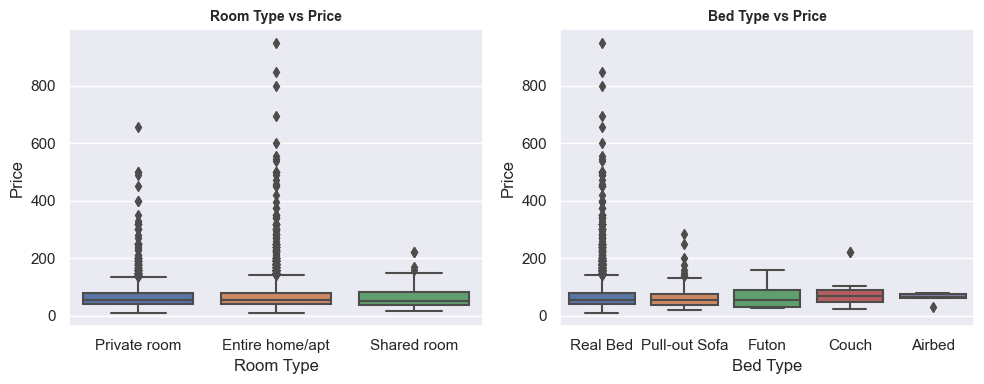

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.boxplot(x='property_room_type', y='target', data=df, ax=ax[0])
ax[0].set_xlabel("Room Type")
ax[0].set_ylabel("Price")
ax[0].set_title("Room Type vs Price", size=10, weight='bold')

sns.boxplot(x='property_bed_type', y='target', data=df, ax=ax[1])
ax[1].set_xlabel("Bed Type")
ax[1].set_ylabel("Price")
ax[1].set_title("Bed Type vs Price", size=10, weight='bold')

plt.tight_layout()
plt.show()

In [ ]:
num_cols = ['property_max_guests',
 'property_bathrooms',
 'property_bedrooms',
 'booking_availability_30',
 'booking_availability_60',
 'booking_availability_90',
 'booking_availability_365',
 'reviews_num',
 'reviews_rating',
 'reviews_acc',
 'reviews_cleanliness',
 'reviews_checkin',
 'reviews_communication',
 'reviews_location',
 'reviews_value',
 'reviews_per_month', 'host_days', 'target']

In [ ]:
len(num_cols)

18

In [ ]:
nums = df.select_dtypes(include=['float', 'int']).columns.tolist()

In [ ]:
stat = df[nums].describe().T

stat

,count,mean,std,min,25%,50%,75%,max
property_lat,6485.0,50.901566,0.141798,50.769144,50.828585,50.843132,50.859097,51.258347
property_lon,6485.0,4.372026,0.031899,4.268333,4.347681,4.367531,4.394850,4.483468
property_max_guests,6485.0,2.995991,1.771488,1.000000,2.000000,2.000000,4.000000,16.000000
property_bathrooms,6473.0,1.140429,0.448585,0.000000,1.000000,1.000000,1.000000,8.000000
property_bedrooms,6476.0,1.203984,0.745181,0.000000,1.000000,1.000000,1.000000,8.000000
property_beds,6474.0,1.739419,1.327635,1.000000,1.000000,1.000000,2.000000,16.000000
host_response_rate,5024.0,92.049761,19.478507,0.000000,95.000000,100.000000,100.000000,100.000000
host_nr_listings,6484.0,6.102869,36.894040,0.000000,1.000000,1.000000,2.000000,591.000000
host_nr_listings_total,6484.0,6.102869,36.894040,0.000000,1.000000,1.000000,2.000000,591.000000
booking_price_covers,6485.0,1.432691,0.965943,1.000000,1.000000,1.000000,2.000000,16.000000


In [ ]:
# create a grid of subplots with 3 rows and 6 columns
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(20, 10))

# loop over the numerical columns and plot a histogram on each subplot
for i, col in enumerate(num_cols):
    row_idx = i // 6  # compute row index from column index
    col_idx = i % 6   # compute column index from column index
    sns.histplot(data=df, x=col, ax=axes[row_idx, col_idx])
    
# adjust the spacing between the subplots and show the plot
fig.tight_layout()
plt.show()

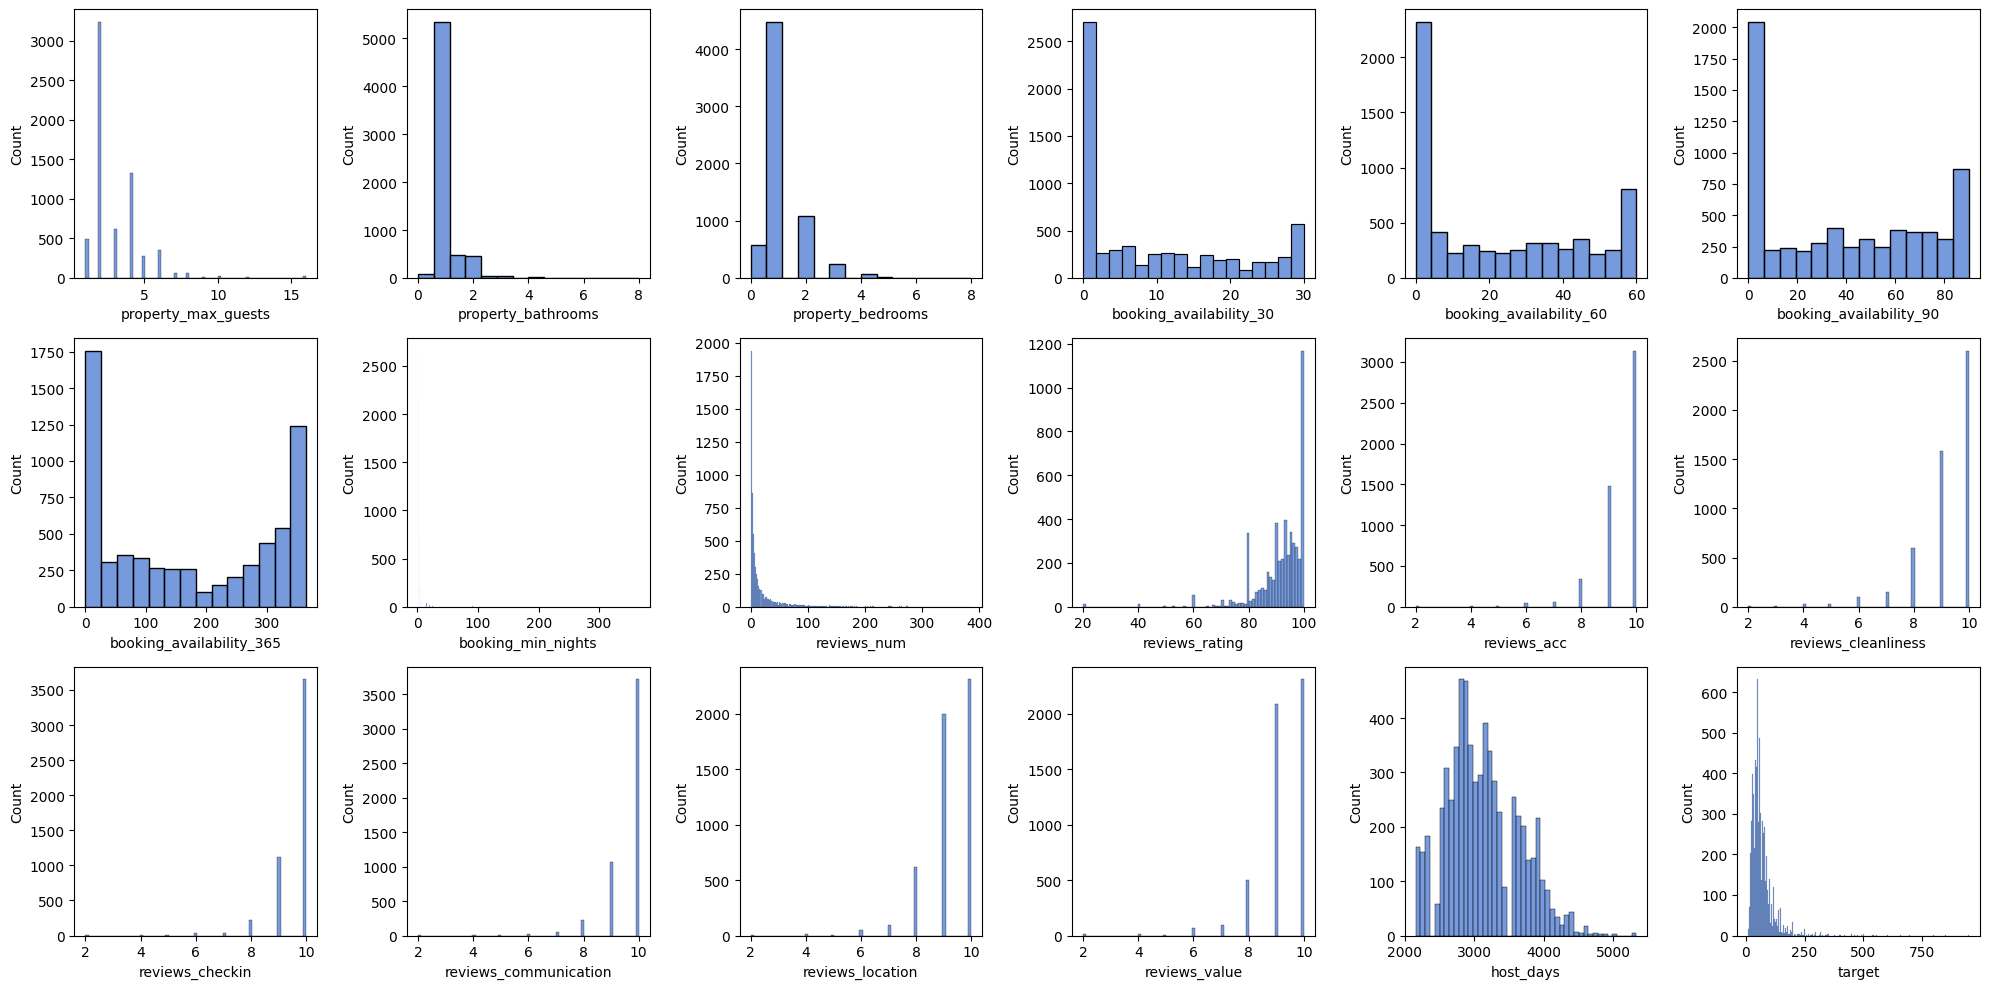

In [ ]:

# create a grid of subplots with 3 rows and 6 columns
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(20, 10))

# loop over the numerical columns and plot a histogram on each subplot
for i, col in enumerate(num_cols):
    row_idx = i // 6  # compute row index from column index
    col_idx = i % 6   # compute column index from column index
    sns.histplot(data=df, x=col, ax=axes[row_idx, col_idx])
    
# adjust the spacing between the subplots and show the plot
fig.tight_layout()
plt.show()

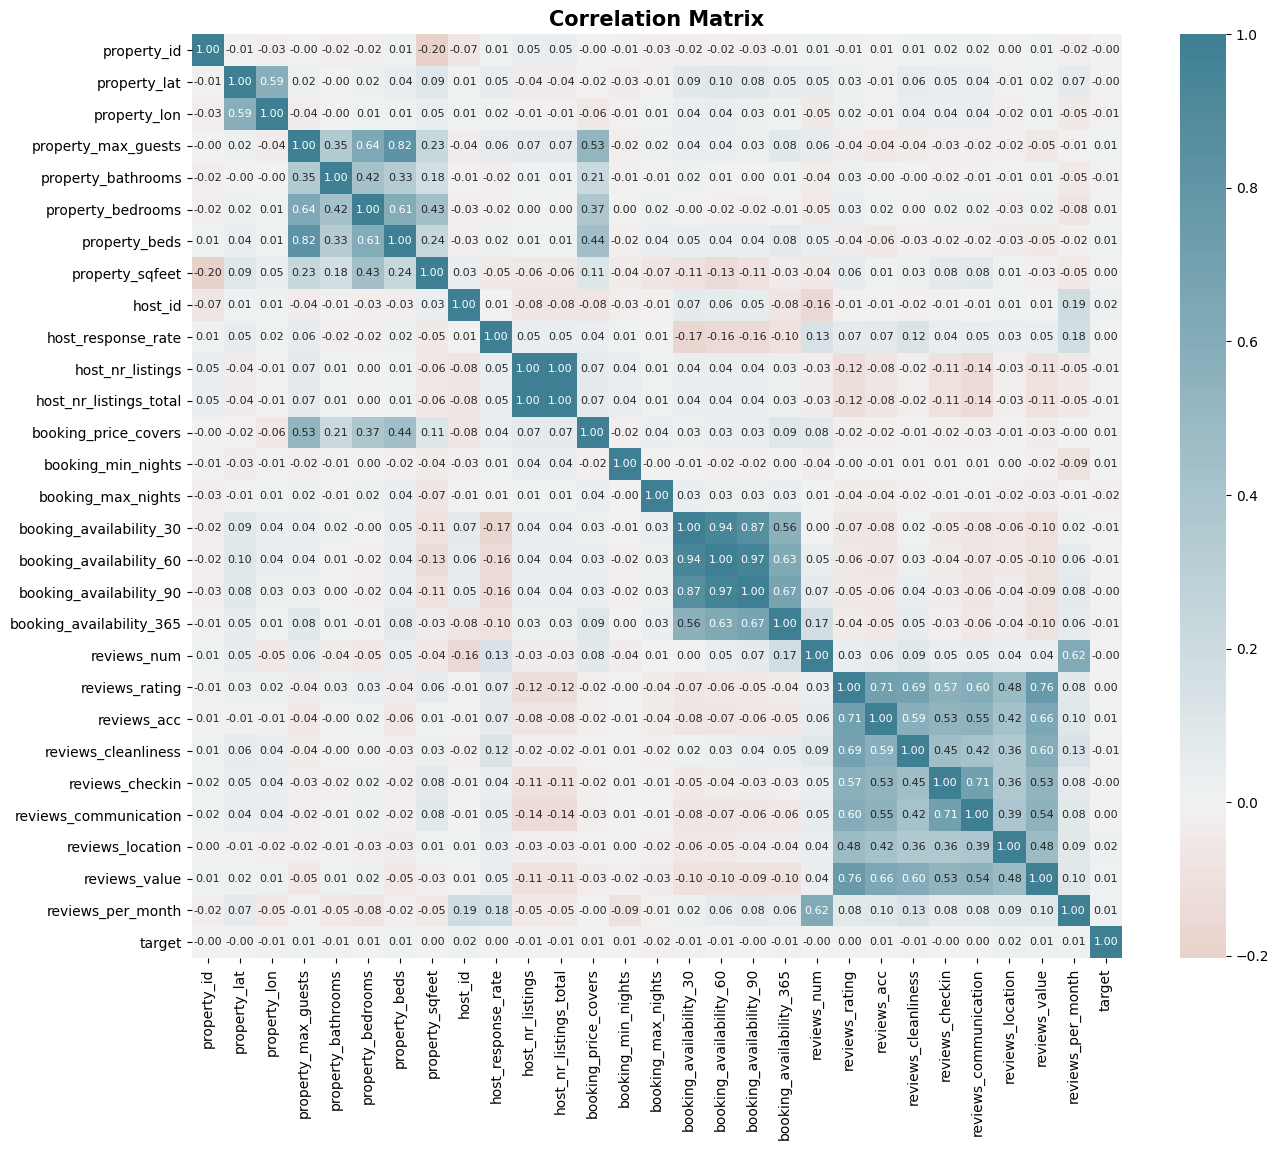

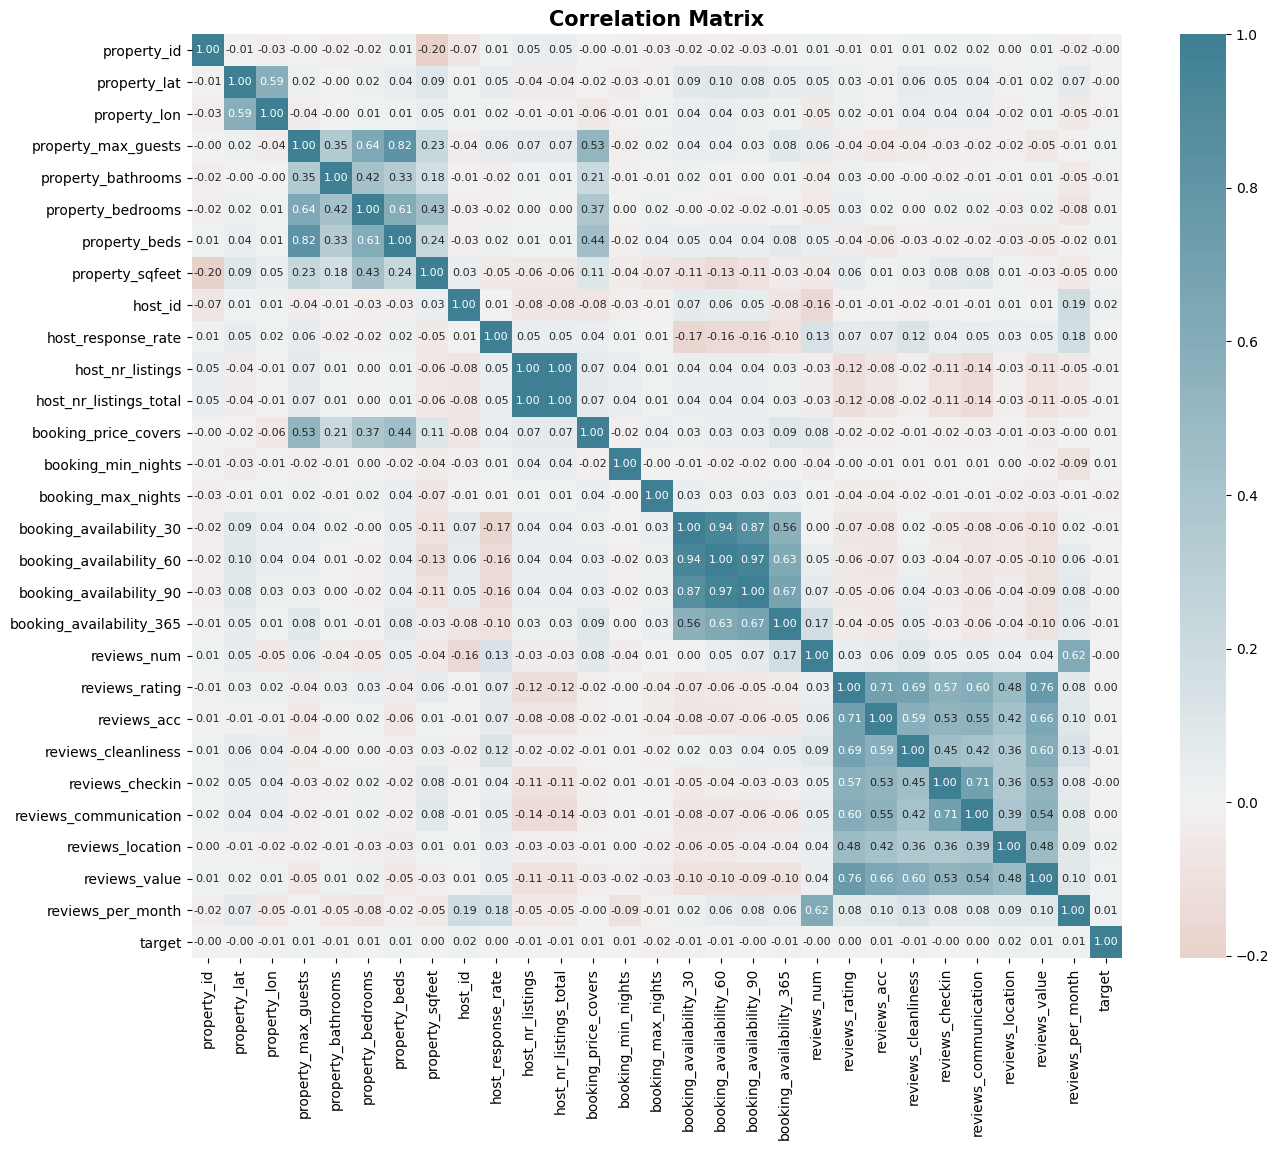

In [ ]:
plt.figure(figsize=(15,12))
palette = sns.diverging_palette(20, 220, n=256)
corr=df.corr(method='pearson')
sns.heatmap(corr, annot=True, fmt=".2f", cmap=palette, center=0, annot_kws={"size": 8})
plt.title("Correlation Matrix",size=15, weight='bold')
plt.show()


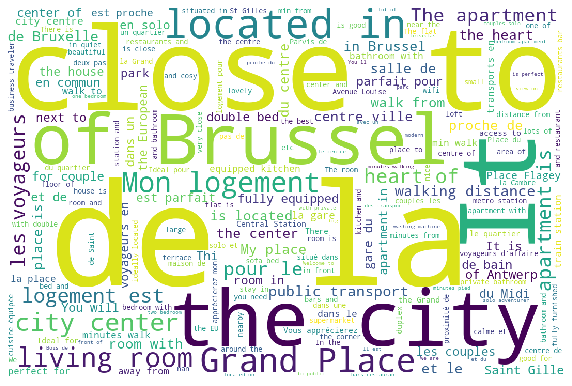

In [ ]:
plt.subplots(figsize=(10,8))
wordcloud = WordCloud(
                          background_color='white',
                          width=1080,
                          height=720
                         ).generate(" ".join(df.property_summary.astype(str)))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('property_summary.png')
plt.show()

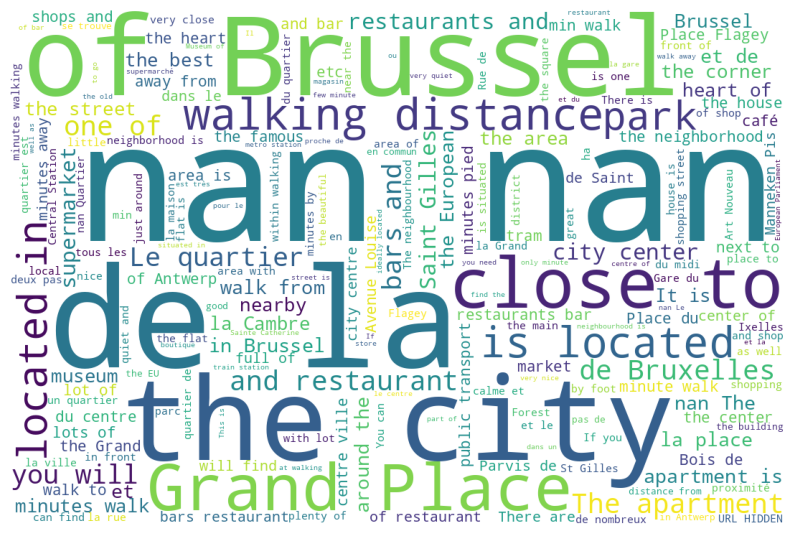

In [ ]:
plt.subplots(figsize=(10,8))
wordcloud = WordCloud(
                          background_color='white',
                          width=1080,
                          height=720
                         ).generate(" ".join(df.property_neighborhood.astype(str)))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('property_neighborhood.png')
plt.show()